In [18]:
using PorousMaterials
using DataFrames
using PyPlot
using DelimitedFiles
using CSV
using Printf

In [19]:
cages = readdlm("all_cages.txt")
nb_cages = length(cages)

74

# Build giant slab of cages arranged into a grid.
(also write labels in same position)

In [20]:
nb_rows = 6
nb_columns = 13
@assert(nb_rows * nb_columns >= length(cages))

In [21]:
nb_atoms = 0
for cage = cages
    atoms, x = read_xyz(cage * "_final_aligned.xyz")
    nb_atoms += length(atoms)
end
nb_atoms

16461

In [22]:
box_size = 42.0

42.0

In [23]:
df_pores = CSV.read("../pywindow_cage_descriptors.csv")
sort!(df_pores, :molecule_diameter_A, rev=true)
df_pores

,cage,molecule_diameter_A,pore_diameter_A,nb_windows
,String⍰,Float64⍰,Float64⍰,Int64⍰
1,MC6,42.8163,21.9184,6
2,IC1,34.3852,14.4642,4
3,DC1,34.3659,9.63252,3
4,GC1,34.323,12.7035,6
5,C26,34.3003,11.2826,6
6,WC1,32.9459,10.3792,4
7,B26,32.6899,12.5123,6
8,MC1,31.6835,10.2738,4
9,C25,31.1188,10.6478,6


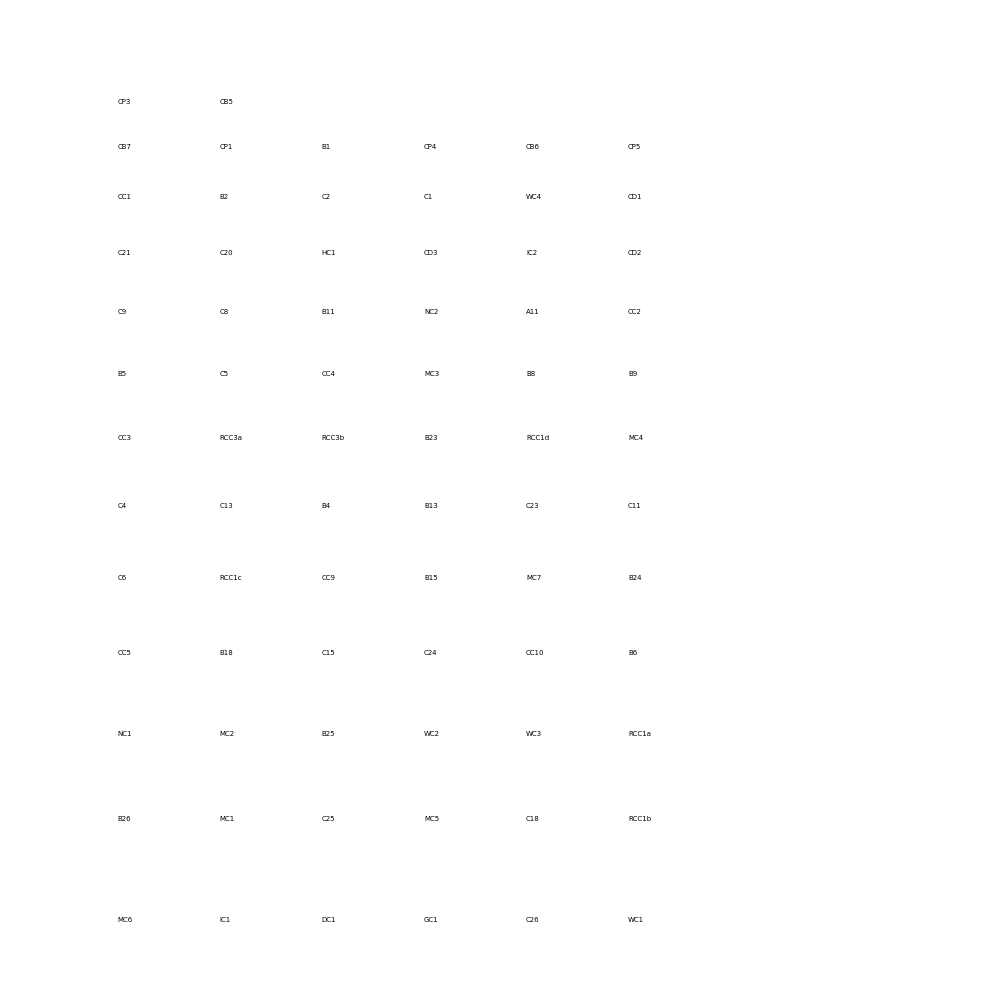

In [24]:
big_xyz = open("grid_of_cages.xyz", "w")
@printf(big_xyz, "%d\n\n", nb_atoms)

z_pos = 0.0
y_pos = 0.0
padding = 4.0

# annotation plot
fig, ax = plt.subplots(figsize=(10,10))
#fig[:patch][:set_visible](false)
ax[:axis]("off")

cage_no = 0 # cage counter
for c = 1:nb_columns
    this_box_height = df_pores[:molecule_diameter_A][cage_no+1] + padding
    z_pos += this_box_height
    for r = 1:nb_rows
        y_pos = box_size * r
        
        if cage_no >= length(cages)
            continue
        end
        # increment
        cage_no += 1
        cage = df_pores[:cage][cage_no]
        
        atoms, x = read_xyz(cage * "_aligned.xyz")
        for a = 1:length(atoms)
            @printf(big_xyz, "%s\t%f\t%f\t%f\n", atoms[a], 
                x[1, a], x[2, a] + y_pos, x[3, a] + z_pos)
        end
        
        plt.annotate(df_pores[:cage][cage_no], (y_pos, z_pos - this_box_height/2), size=5)
    end
end
close(big_xyz)
plt.scatter([30], [30], color="w")
plt.scatter([380], [380], color="w")

# plt.ylim([30, 380])
plt.axis("square")
# plt.gca()[:set_ylim](30, 380)
# plt.gca()[:set_xlim](30, 380)
plt.tight_layout()
#plt.xlim([40, 275])
plt.savefig("cage_labels.pdf", transparent=true, format="pdf")
plt.show() # labels

draw a scale bar 10 A = 1 nm

In [25]:
vtkfile = open("scale_bar.vtk", "w")
@printf(vtkfile, """
    # vtk DataFile Version 2.0
    unit cell boundary
    
    ASCII
    DATASET POLYDATA
    POINTS 2 double
    0.000 %.3f %.3f
    0.000 %.3f %.3f
    LINES 1 3
    2 0 1""",
    y_pos - 5.0, z_pos,
    y_pos + 5.0, z_pos)
close(vtkfile)
run(`cat scale_bar.vtk`)

# vtk DataFile Version 2.0
unit cell boundary

ASCII
DATASET POLYDATA
POINTS 2 double
0.000 247.000 369.100
0.000 257.000 369.100
LINES 1 3
2 0 1

Process(`cat scale_bar.vtk`, ProcessExited(0))

# LaTeX code to add the cages in the SI

In [26]:
f = open("latex_code_for_viz.tex", "w")
@printf(f, "\\begin{figure}[!h]\n")
@printf(f, "\\centering\n")
for (c, cage) in enumerate(cages)
    @printf(f, "\\subfloat[%s]{\\includegraphics[width=0.25\\columnwidth]{../all_cages/%s_final_aligned.png}}\n",
        cage, cage)
    if c % 12 == 0
        # phantom caption is so that it is all labeled as same fig 1 not fig 5
        @printf(f, "\\phantomcaption \\end{figure}\n\\begin{figure}\n\\ContinuedFloat \\centering\n")
    elseif c % 3 == 0
        @printf(f, "\\qquad\n")
    end
end
@printf(f, "\\caption{Visualizations of the structures of all 74 porous organic cage molecules analyzed in this study.
    The \\texttt{.xyz} files of these cages are from Miklitz et al. and Greenaway et al. \\cite{miklitz2017computational,greenaway2018high};
    see these references for the naming conventions. The cages are visualized in their centered and aligned states
    in the \$[-20,20]^3\$ \$\\angstrom\$
    snapshot box in preparation for taking the 3D cage cavity image.}\n")
@printf(f, "\\label{fig:allcagesdetailed}\n")
@printf(f, "\\end{figure}\n")
close(f)

In [27]:
run(`cat latex_code_for_viz.tex`)

\begin{figure}[!h]
\centering
\subfloat[A11]{\includegraphics[width=0.25\columnwidth]{../all_cages/A11_final_aligned.png}}
\subfloat[B11]{\includegraphics[width=0.25\columnwidth]{../all_cages/B11_final_aligned.png}}
\subfloat[B13]{\includegraphics[width=0.25\columnwidth]{../all_cages/B13_final_aligned.png}}
\qquad
\subfloat[B15]{\includegraphics[width=0.25\columnwidth]{../all_cages/B15_final_aligned.png}}
\subfloat[B18]{\includegraphics[width=0.25\columnwidth]{../all_cages/B18_final_aligned.png}}
\subfloat[B1]{\includegraphics[width=0.25\columnwidth]{../all_cages/B1_final_aligned.png}}
\qquad
\subfloat[B23]{\includegraphics[width=0.25\columnwidth]{../all_cages/B23_final_aligned.png}}
\subfloat[B24]{\includegraphics[width=0.25\columnwidth]{../all_cages/B24_final_aligned.png}}
\subfloat[B25]{\includegraphics[width=0.25\columnwidth]{../all_cages/B25_final_aligned.png}}
\qquad
\subfloat[B26]{\includegraphics[width=0.25\columnwidth]{../all_cages/B26_final_aligned.png}}
\subfloat[B2]{\includ

Process(`cat latex_code_for_viz.tex`, ProcessExited(0))